In [51]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [52]:
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
data_test_plus_train = pd.concat([data_train,data_test])

data_test_plus_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [53]:

original_train = train.copy() 
original_test = test.copy()

full_data = [train, test]

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#SibSp nombre de freres et soeurs/Epouses ; Parch - Number of Parents/Children Aboard;
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    #fare = tarif
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# suppression des NULL dans column Age
for dataset in full_data:
    age_mean = dataset['Age'].mean()
    age_std = dataset['Age'].std() #Ecart Type
    print(age_std)
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Fonction pour avoir les titre
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Si le titre Existe le returneeeeeeeee.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Grouper tout les titre rare en un seul "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    #title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    #dataset['Title'] = dataset['Title'].map(title_mapping)
    #dataset['Title'] = dataset['Title'].fillna(0)
#Embarked - Port d'Embarquement (C = Cherbourg; Q = Queenstown; S = Southampton)
    #dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


14.526497332334044
14.18120923562442


In [54]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [55]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,22,0,7.2500,S,0,2,0,Mr
1,1,1,0,38,0,71.2833,C,1,2,0,Mrs
2,1,3,0,26,0,7.9250,S,0,1,1,Miss


In [83]:
ohe = OneHotEncoder()
test_emb_tittle_array = ohe.fit_transform(test[['Embarked','Title']]).toarray()
train_emb_tittle_array = ohe.fit_transform(train[['Embarked','Title']]).toarray()
train_emb_tittle_array

array([[0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [92]:
#ohe_labels = np.array([ohe.categories_[0],ohe.categories_[1]])
#ohe_labels = np.ravel([ohe.categories_[0],ohe.categories_[1]])
ohe_labels = np.array(['C', 'Q', 'S','Master', 'Miss', 'Mr', 'Mrs', 'Rare'])

In [95]:
test_ohe =pd.DataFrame(test_emb_tittle_array, columns = ohe_labels)
train_ohe =pd.DataFrame(train_emb_tittle_array, columns = ohe_labels)

In [145]:
final_test = pd.concat([test,test_ohe],axis=1)
final_test = final_test.drop(['Embarked','Title'],axis=1)
final_test

,Pclass,Sex,Age,Parch,Fare,Has_Cabin,FamilySize,IsAlone,C,Q,S,Master,Miss,Mr,Mrs,Rare
0,3,1,34,0,7.8292,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,0,47,0,7.0000,0,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,1,62,0,9.6875,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,1,27,0,8.6625,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3,0,22,1,12.2875,0,3,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,32,0,8.0500,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
414,1,0,39,0,108.9000,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
415,3,1,38,0,7.2500,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
416,3,1,35,0,8.0500,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [116]:
final_train = pd.concat([train,train_ohe],axis=1)
final_train = final_train.drop(['Embarked','Title'],axis=1)
final_train

,Survived,Pclass,Sex,Age,Parch,Fare,Has_Cabin,FamilySize,IsAlone,C,Q,S,Master,Miss,Mr,Mrs,Rare
0,0,3,1,22,0,7.2500,0,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,0,38,0,71.2833,1,2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,26,0,7.9250,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,1,0,35,0,53.1000,1,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,3,1,35,0,8.0500,0,1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,13.0000,0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,1,1,0,19,0,30.0000,1,1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,0,3,0,26,2,23.4500,0,4,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
889,1,1,1,26,0,30.0000,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [117]:
X_test = final_test
#y_test = test_drop['Survived']

X_train = final_train.drop(['Survived'], axis=1)
y_train = final_train['Survived']
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [137]:
#model_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=10, max_depth=5)
# Entraînement du modèle d'arbre
#model_tree.fit(X_train, y_train)

# Visualisation de l'arbre
#tree.plot_tree(model_tree)
#plt.show()

In [135]:
score = []
for i in range(50):
    model_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,max_depth=i+1)
    model_tree.fit(X_train, y_train)
    score.append(model_tree.score(X_train,y_train))

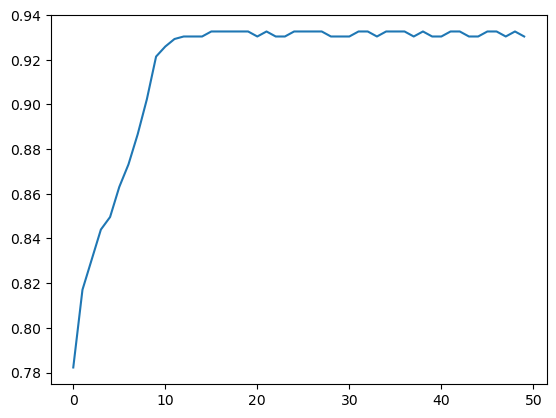

In [136]:
x = list(range(50))
plt.plot(x,score)

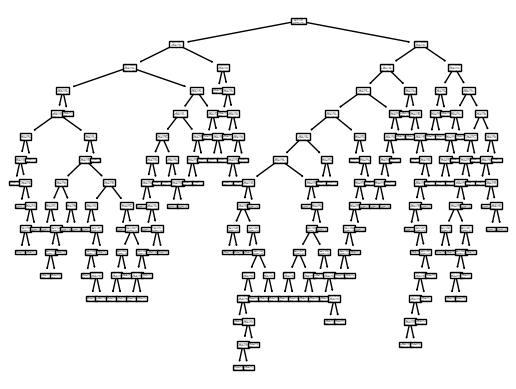

In [138]:
model_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=10, max_depth=15)
# Entraînement du modèle d'arbre
model_tree.fit(X_train, y_train)
#Visualisation de l'arbre
tree.plot_tree(model_tree)
plt.show()

In [144]:
prediction = model_tree.predict(X_test)
#plt.scatter(X_train['Age'],y_train);
#prediction

In [140]:
def survie(model,Pclass=1,Sex=1,Age=25,Parch=0,Fare=5.25,Has_Cabin=0,FamilySize=1,IsAlone=1,C=0,Q=0,S=1,Master=0,Miss=0,Mr=1,Mrs=0,Rare=0):
    x = np.array([Pclass,Sex,Age,Parch,Fare,Has_Cabin,FamilySize,IsAlone,C,Q,S,Master,Miss,Mr,Mrs,Rare]).reshape(1,16)
    print(model.predict(x))

In [143]:
survie(model_tree,1,0,22,1,7.51,1,2,0)

[0]


C:\Users\CISSE Issa\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
